In [ ]:
#notebook to do cocrystal analysis of the glide poses

In [15]:
import mdtraj as md
import glob
import numpy as np
import math

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib as mplt
from mpl_toolkits.axes_grid1 import make_axes_locatable

font = {'family' : 'sans-serif',
        'sans-serif': 'Arial'}

mplt.rc('font', **font)

In [3]:

coxtals = glob.glob('/home/jegan/cocrystals/prepared_1/*')
coxnames = [name.split('/')[5][:4] for name in coxtals]
coxnames.sort()
#print(coxnames)
print(len(coxnames))


55


In [5]:
#definition of new binding atoms that are present in all cocrystals (check_pdbs_binding.py)

file = '/home/jegan/cocrystals/new_binding_atoms.csv'     
df0 = pd.read_csv(file)
#print(df0['Num'])
new_binding = [1035, 1038, 1040, 1044, 2854, 2116, 323, 1133, 1135, 3208, 2214, 2220, 1715, 3312, 3316, 328, 339, 342, 350, 359, 361, 363, 366, 367, 2452, 2454, 2465, 2469, 2473, 2475, 946, 2487, 2835, 963, 2506, 2839, 2844, 1008, 1009, 1013, 1016]


def select_string(lis):
    s = ''
    for x in lis:
        s += 'index '+str(x)+' or '
    return s[:-4]

def b_ats_coxtal(traj): #binding atom residue indices for cocrystals
    indices = []
    err = []
    for x in range(len(df0['Res'])):
        name = df0['Res'][x]
        num = df0['Num'][x]
        typ = df0['Typ'][x]
        
        target = traj.topology.select('name '+typ+' and resname '+name+' and residue '+str(int(num)-1))
        #target = traj.topology.select('residue')
        if len(target) != 0:
            indices.append(target[0])
        else:
            err.append([name, num-1, typ])
    return indices, err
    

In [21]:
#calculating rmsds to 5qc4 in order for each coxtal

rmsds = []
path = '/home/jegan/cocrystals/prepared_1/'

ref = md.load(path+'5qc4.pdb')
ref_ind = b_ats_coxtal(ref)
ref_sel = ref.atom_slice(ref.topology.select(select_string(ref_ind[0])))

#print(ref_sel)
for x in coxnames:
    target = md.load(path+x+'.pdb')
    tar_ind = b_ats_coxtal(target)
    tar_sel = target.atom_slice(target.topology.select(select_string(ref_ind[0])))
    #print(tar_sel)
    rmsd = md.rmsd(tar_sel, ref_sel) *10
    rmsds.append(rmsd[0])
print(rmsds) 

[2.111923, 4.2015476, 4.2217727, 1.6962566, 1.5632322, 0.8091668, 0.72996444, 1.360714, 1.5335422, 5.4911585, 4.328657, 0.7198247, 0.97354716, 2.1266215, 1.4655771, 0.9061814, 1.6706175, 1.7009344, 1.6917144, 0.7505893, 0.61415786, 0.55308366, 0.7981219, 0.8764097, 0.7977954, 0.858801, 0.74968386, 0.6480367, 0.9056165, 0.753941, 0.5773636, 1.6823775, 1.7062539, 0.40704805, 0.0, 0.964435, 0.43543056, 1.6391045, 0.74737185, 0.5742774, 0.7262459, 0.6979985, 0.63886935, 0.9085399, 0.5260453, 0.9469697, 0.8145874, 0.80483186, 0.95630676, 0.930447, 7.2160654, 7.2280884, 7.5375395, 7.238984, 7.2934575]


In [23]:
print(len(rmsds))

55


In [36]:
#getting receptor numbers

data = pd.read_csv('/scratch/jegan/GLIDE_coxtal_docking/coxtal_docking/scores.csv')
receps = [int(x) for x in data['best receptor'] if not math.isnan(x)]
print(len(receps))
#print(receps)

459


459
459


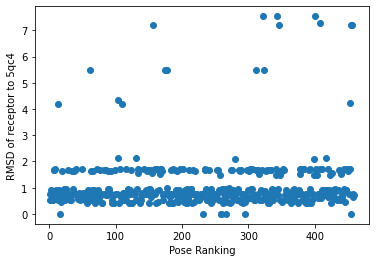

In [58]:
# looking at the rmsds of the receptors to the original pose we used
# ranked for the cocrystal structures

fig, ax = plt.subplots()

x = range(1,460)
y = [rmsds[p-1] for p in receps]

print(len(x))
print(len(y))

ax.scatter(x, y)

ax.set_xlabel('Pose Ranking')
ax.set_ylabel('RMSD of receptor to 5qc4')
plt.savefig('./figures/rank_rmsd.png', dpi = 300)

459
459


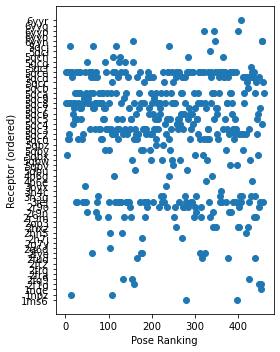

In [90]:
#seeing the most common receptors

fig, ax = plt.subplots(figsize = (4,5))

x = range(1,460)
y =  receps

print(len(x))
print(len(y))

ax.scatter(x, y)

ax.set_xlabel('Pose Ranking')
ax.set_yticks(range(1,len(coxnames)+1))
ax.set_yticklabels(coxnames)
ax.set_ylabel('Receptor (ordered)')
plt.tick_params(axis='y', which='major', labelsize=10)
plt.tight_layout()

plt.savefig('./figures/rank_recep.png', dpi = 300)

In [68]:
from collections import Counter
test = Counter(receps)

8

55
55


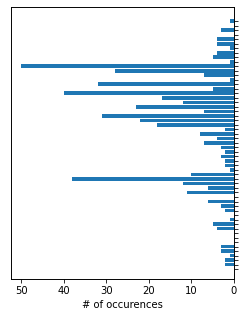

In [91]:

fig, ax = plt.subplots(figsize = (4,5))

x = range(1, max(receps)+1)
y = [Counter(receps)[p] for p in x]

print(len(x))
print(len(y))

#ax.set_yticks(range(len(coxnames)+1))
#ax.set_yticklabels(coxnames)
ax.set_xlabel('# of occurences')

ax.set_yticklabels([]) # Hide the left y-axis tick-labels
ax.set_yticks([]) # Hide the left y-axis ticks
ax.invert_xaxis() 
ax1 = ax.twinx() # Create a twin x-axis
ax1.barh(x, y) # Plot using `ax1` instead of `ax`
ax1.set_yticks(range(len(coxnames)+1))
ax1.set_yticklabels([])
#ax1.set_ylabel('Receptors')

plt.savefig('./figures/rank_occurences.png', dpi = 300)

In [74]:
score = {}

for ind,v in enumerate(y):
    if v > 10:
        name = coxnames[ind -1]
        score[name] = v
print(score)

{'2op3': 11, '2r9n': 12, '2r9o': 38, '5qbz': 18, '5qc0': 22, '5qc2': 31, '5qc4': 23, '5qc5': 12, '5qc6': 17, '5qc7': 40, '5qc9': 32, '5qcc': 28, '5qcd': 50}
